In [64]:
import sys
sys.path.append('../code')
import torch as t 
import numpy as np
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

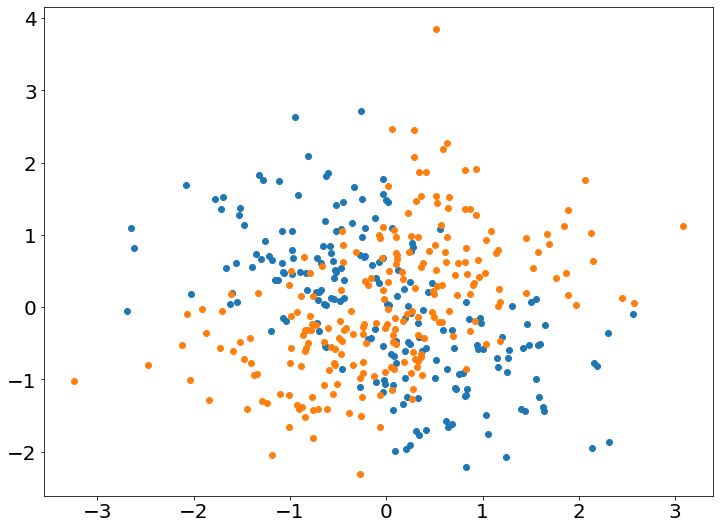

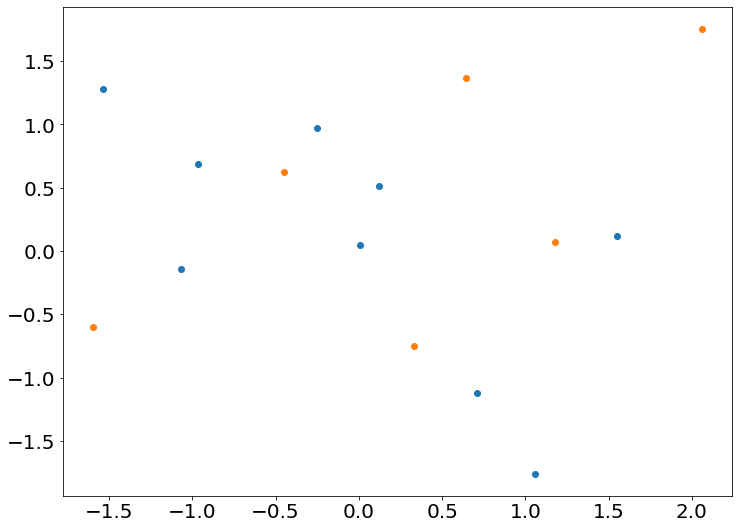

In [2]:
np.random.seed(42)
teacher_train_size, student_train_size, student_validation_size, test_size = 200, 15, 15, 200
total_size =  sum([teacher_train_size, student_train_size, student_validation_size, test_size])
eps = .5
"""
Y генерируется как:
    sign (x1 * x2) + шум
    
Признаки для учителя:
    x1; x2; индикатор, что x1 >0 и x2>0 
    Последний признак коррелирует с Y, но не покрывает его
    
Признаки для ученика:
    x1; x2; индикатор, что x1 >0 и x2>0 
    Последний признак отличается от Y из-за шума
        
    
"""
# полные данные
x_big = np.random.randn(total_size, 2)
y_big = (np.sign(x_big[:,0]*x_big[:,1]+np.random.randn(total_size)*eps)+1)//2
x_big = np.vstack([x_big[:,0], x_big[:,1],  (np.sign(x_big[:,0])+np.sign(x_big[:,1]) >0.1)*1.0, 
                   x_big[:,0]*x_big[:,1]]).T

# обучение учителя. NB: не пересекается с выборкой для обучения ученика, так проще подобрать параметры
x_ttrain = t.tensor(x_big[:teacher_train_size], dtype=t.float32)
y_ttrain = t.tensor(y_big[:teacher_train_size], dtype=t.long)


# обучение ученика
x_train = t.tensor(x_big[teacher_train_size:teacher_train_size+student_train_size], dtype=t.float32)
y_train = t.tensor(y_big[teacher_train_size:teacher_train_size+student_train_size], dtype=t.long)

# валидация, в этом ноутбуке не используется
x_val = t.tensor(x_big[teacher_train_size+student_train_size:teacher_train_size+student_train_size+student_validation_size], 
                 dtype=t.float32)
y_val = t.tensor(y_big[teacher_train_size+student_train_size:teacher_train_size+student_train_size+student_validation_size], dtype=t.long)


x_test = t.tensor(x_big[-test_size:], dtype=t.float32)
y_test = t.tensor(y_big[-test_size:], dtype=t.long)

plt.scatter(x_big[y_big==0,0], x_big[y_big==0,1])
plt.scatter(x_big[y_big==1,0], x_big[y_big==1,1])

plt.show()

plt.scatter(x_train[y_train==0,0], x_train[y_train==0,1])
plt.scatter(x_train[y_train==1,0], x_train[y_train==1,1])



In [3]:
class LogReg(t.nn.Module):
    def __init__(self, idx):
        t.nn.Module.__init__(self)
        self.lin = t.nn.Linear(len(idx), 2) 
        self.idx = idx        
    
    def forward(self, x):
        return self.lin(x[:, self.idx])
    
        

In [4]:
def accuracy(student, x,y):
    student.eval()
    total = 0 
    correct = 0
    with t.no_grad():
        out = student(x)
        correct += t.eq(t.argmax(out, 1), y).sum()
        total+=len(x)
    student.train()
    return (correct/total).cpu().detach().numpy()

In [5]:
# обучение учителя
t.manual_seed(0)
teacher = LogReg([0,1,2])
optim = t.optim.Adam(teacher.parameters())    
crit = t.nn.CrossEntropyLoss()
for e in range(10000):                                
    teacher.zero_grad() 
    loss = crit(teacher(x_ttrain), y_ttrain)
    loss.backward()
    optim.step()    
    
    teacher.eval()
    if e%1000==0:
        print (accuracy(teacher, x_test, y_test ))    
    teacher.train()
    



0.5
0.66
0.665
0.69
0.69
0.69
0.69
0.69
0.69
0.69


In [6]:
# обучение студента без дистилляции
student = LogReg([0,1,3])
optim = t.optim.Adam(student.parameters())    
crit = t.nn.CrossEntropyLoss()
for e in range(10000):                                
    student.zero_grad()            
    loss = crit(student(x_train), y_train)
    loss.backward()
    optim.step()        
    student.eval()
    if e%1000==0:
        print (accuracy(student, x_test, y_test ))    
    student.train()
    



0.48
0.69
0.725
0.745
0.76
0.755
0.755
0.755
0.755
0.755


In [7]:
kl = t.nn.KLDivLoss(reduction='batchmean')
sm = t.nn.Softmax(dim=1)

def distill(out, batch_logits, temp):
    g = sm(out/temp)
    f = t.nn.functional.log_softmax(batch_logits/temp)    
    return kl(f, g)

In [8]:
# полная дистилляция
beta1 = 0.0
beta2 = 1.0
temp = 1.0
student = LogReg([0,1,3])
optim = t.optim.Adam(student.parameters())    
crit = t.nn.CrossEntropyLoss()
teacher.eval()
for e in range(10000):                                
    student.zero_grad()    
    out = student(x_train)
    student_loss = crit(out, y_train)            
    distillation_loss = distill(out, teacher(x_train), temp)
    loss = beta1 * student_loss + beta2*distillation_loss        
    loss.backward()
    optim.step()    
    
    student.eval()
    if e%1000==0:
        print (accuracy(student, x_test, y_test ))    
    student.train()
    

<ipython-input-7-8c26b1136af2>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = t.nn.functional.log_softmax(batch_logits/temp)


0.65
0.605
0.605
0.605
0.605
0.605
0.605
0.605
0.605
0.605


In [11]:
# дистилляция с разными коэффициентами
beta1 = 1.0
beta2 = .5
temp = 1.0
student = LogReg([0,1,3])
optim = t.optim.Adam(student.parameters())    
crit = t.nn.CrossEntropyLoss()
teacher.eval()
for e in range(10000):                                
    student.zero_grad()    
    out = student(x_train)
    student_loss = crit(out, y_train)            
    distillation_loss = distill(out, teacher(x_train), temp)
    loss = beta1 * student_loss + beta2*distillation_loss        
    loss.backward()
    optim.step()    
    
    student.eval()
    if e%1000==0:
        print (accuracy(student, x_test, y_test ))    
    student.train()
    

<ipython-input-9-8c26b1136af2>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = t.nn.functional.log_softmax(batch_logits/temp)


0.395
0.71
0.82
0.81
0.815
0.805
0.805
0.805
0.805
0.805


In [9]:
res_opt_full = []

In [30]:
# дистилляция с оптимизацией гиперапарметров

def param_loss(batch,model,h):
    x,y,batch_logits = batch
    #beta,temp = h
    beta,beta2,temp = h
    out = model(x)
    beta = t.clamp(beta, 0.01, 0.99)
    beta2 = t.clamp(beta2, 0.01, 0.99)
    temp = t.clamp(temp, 0.1, 10.0)
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)            
    #loss = (1-beta) * student_loss + beta*distillation_loss
    loss = beta * distillation_loss + beta2 * student_loss
    return loss

def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

results_opt = []

beta1 = t.nn.Parameter(t.tensor(np.random.uniform()), requires_grad=True)
beta2 = t.nn.Parameter(t.tensor(np.random.uniform()), requires_grad=True)
temp = t.nn.Parameter(t.tensor(10**np.random.uniform(low=-1, high=1)), requires_grad=True)
h = [beta1, beta2, temp]

student = LogReg([0,1,3])
optim = t.optim.Adam(student.parameters())    
optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))   
hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
crit = t.nn.CrossEntropyLoss()
teacher.eval()
for e in range(10000):
    
    optim2.zero_grad()            
    hyper_grad_calc.calc_gradients((x_train,y_train,teacher(x_train)), (x_test, y_test))
    optim2.step()
    
    optim.zero_grad()
    out = student(x_train)
    loss = param_loss((x_train,y_train,teacher(x_train)), student,h)
    loss.backward()
    optim.step()    
    student.eval()
    if e%1000==0:
        print(accuracy(student, x_test, y_test), float(beta1.detach().numpy()), float(beta2.detach().numpy()), float(temp.detach().numpy()))
#         for p in student.parameters():
#             print(p)
#         print('------------------------------------------------------------------------------------')
#     student.train()
        results_opt.append([e, float(accuracy(student, x_test, y_test)), float(beta1.detach().numpy()), float(beta2.detach().numpy()), float(temp.detach().numpy())])

<ipython-input-7-8c26b1136af2>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = t.nn.functional.log_softmax(batch_logits/temp)


0.575 0.8679458498954773 0.8050167560577393 3.8024888038635254
0.775 0.9908550977706909 0.17398983240127563 3.577864170074463
0.61 0.9908550977706909 0.008309952914714813 3.2835910320281982
0.555 0.9908550977706909 0.008309952914714813 3.204294204711914
0.555 0.9908550977706909 0.008309952914714813 3.150416135787964
0.555 0.9908550977706909 0.008309952914714813 3.0945968627929688
0.555 0.9908550977706909 0.008309952914714813 3.037144184112549
0.555 0.9908550977706909 0.008309952914714813 2.979024648666382
0.555 0.9908550977706909 0.008309952914714813 2.9208505153656006
0.555 0.9908550977706909 0.008309952914714813 2.862833261489868


In [31]:
res_opt_full.append(results_opt)

In [32]:
len(res_opt_full)

5

In [66]:
res_full = []

In [79]:
# дистилляция со случайными гиперпараметрами

def param_loss(batch,model,h):
    x,y,batch_logits = batch
    #beta,temp = h
    beta,beta2,temp = h
    out = model(x)
    beta = t.clamp(beta, 0.01, 0.99)
    beta2 = t.clamp(beta2, 0.01, 0.99)
    temp = t.clamp(temp, 0.1, 10.0)
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)            
    #loss = (1-beta) * student_loss + beta*distillation_loss
    loss = beta * distillation_loss + beta2 * student_loss
    return loss

results_rand = []
results_rand_param = []

beta1 = t.nn.Parameter(t.tensor(np.random.uniform()), requires_grad=True)
beta2 = t.nn.Parameter(t.tensor(np.random.uniform()), requires_grad=True)
temp = t.nn.Parameter(t.tensor(10**np.random.uniform(low=-1, high=1)), requires_grad=True)
h = [beta1, beta2, temp]

student = LogReg([0,1,3])
optim = t.optim.Adam(student.parameters())    
crit = t.nn.CrossEntropyLoss()
teacher.eval()
for e in range(10000):
    optim.zero_grad()
    out = student(x_train)
    loss = param_loss((x_train,y_train,teacher(x_train)), student,h)
    loss.backward()
    optim.step()    
    student.eval()
    if e%1000==0:
        print(accuracy(student, x_test, y_test), float(beta1.detach().numpy()), float(beta2.detach().numpy()), float(temp.detach().numpy()))
#         for p in student.parameters():
#             print(p)
#         print('------------------------------------------------------------------------------------')
#     student.train()
        results_rand.append([e, float(accuracy(student, x_test, y_test)), float(beta1.detach().numpy()), float(beta2.detach().numpy()), float(temp.detach().numpy())])
        par = [p.detach().numpy().flatten() for p in student.parameters()]
        results_rand_param.append(np.concatenate((par[0], par[1])))

<ipython-input-7-8c26b1136af2>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = t.nn.functional.log_softmax(batch_logits/temp)


0.605 0.17483863234519958 0.5025660991668701 0.627084493637085
0.795 0.17483863234519958 0.5025660991668701 0.627084493637085
0.795 0.17483863234519958 0.5025660991668701 0.627084493637085
0.79 0.17483863234519958 0.5025660991668701 0.627084493637085
0.79 0.17483863234519958 0.5025660991668701 0.627084493637085
0.79 0.17483863234519958 0.5025660991668701 0.627084493637085
0.79 0.17483863234519958 0.5025660991668701 0.627084493637085
0.79 0.17483863234519958 0.5025660991668701 0.627084493637085
0.79 0.17483863234519958 0.5025660991668701 0.627084493637085
0.79 0.17483863234519958 0.5025660991668701 0.627084493637085


In [80]:
res_full.append(results_rand_param)

In [81]:
len(res_full)

5

In [39]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

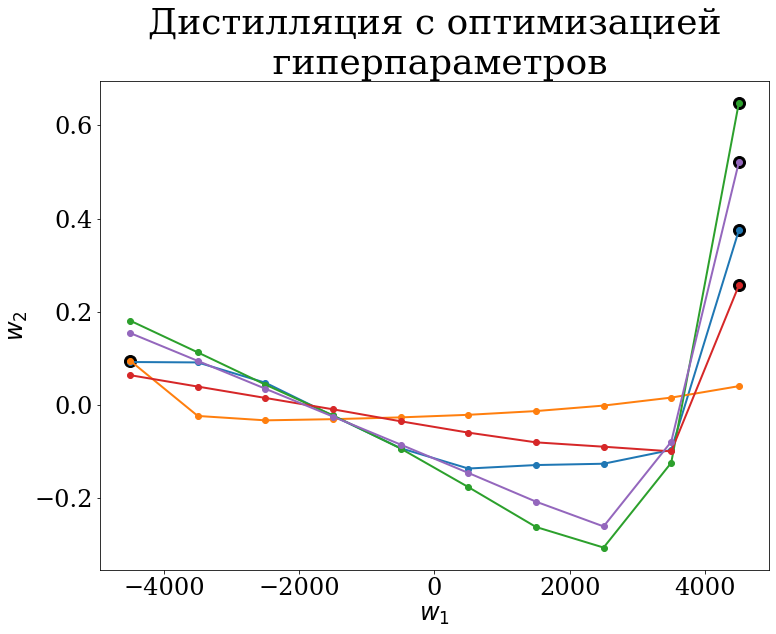

In [65]:
num = 0
for res in res_opt_full:
    num+=1
    pca = PCA(n_components=2)
    par = pca.fit_transform(res)
    # for i in range(3):
    #     ax.plot(beta_h[:, i], beta2_h[:, i], temp_h[:, i], label='оптимизация гипепараметров')
    plt.plot(par[:, 0],par[:, 1], marker='.', label=str(num))
    plt.scatter(par[0, 0],par[0, 1], color='black')
    
plt.title('Дистилляция с оптимизацией\n гиперпараметров')    
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
#plt.legend()
plt.savefig('plot_params_opt.pdf')
#plt.show()

# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

<IPython.core.display.Javascript object>


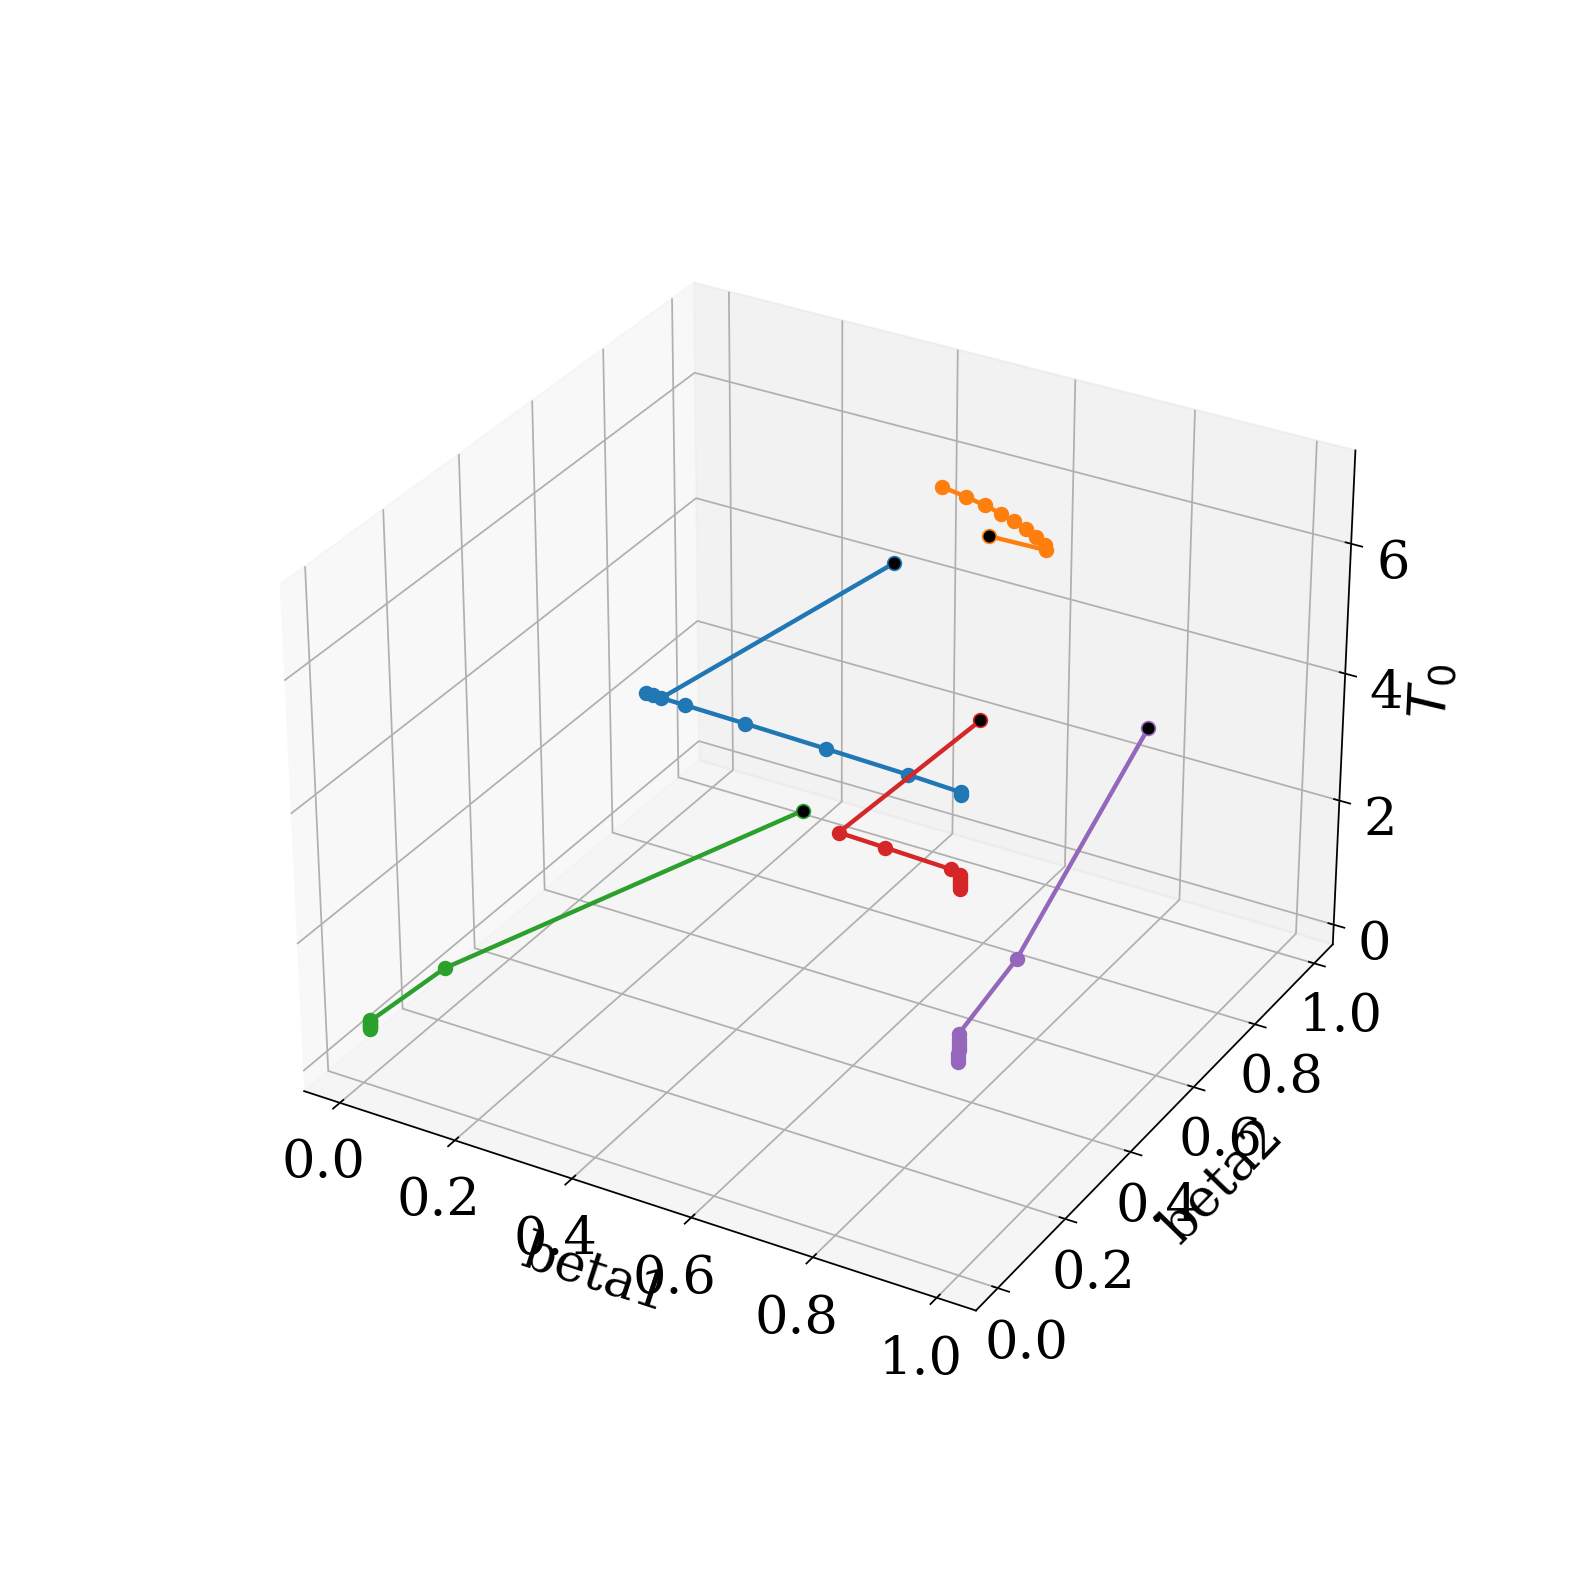

In [63]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))#=(5, 5))
ax = fig.add_subplot(111, projection='3d')

for res in res_opt_full:
    temp = np.array(res)[:, 4]
    beta1 = np.array(res)[:, 2]
    beta2 = np.array(res)[:, 3]
    # for i in range(3):
    #     ax.plot(beta_h[:, i], beta2_h[:, i], temp_h[:, i], label='оптимизация гипепараметров')
    ax.plot(beta1, beta2, temp, marker='.', label='оптимизация гипепараметров')
    ax.scatter(beta1[0], beta2[0], temp[0], color='black')
    
ax.set_xlabel('beta1')
ax.set_ylabel('beta2')
ax.set_zlabel('$T_0$')
#plt.legend()
plt.show()
plt.savefig('plot_beta_temp3.pdf')

# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

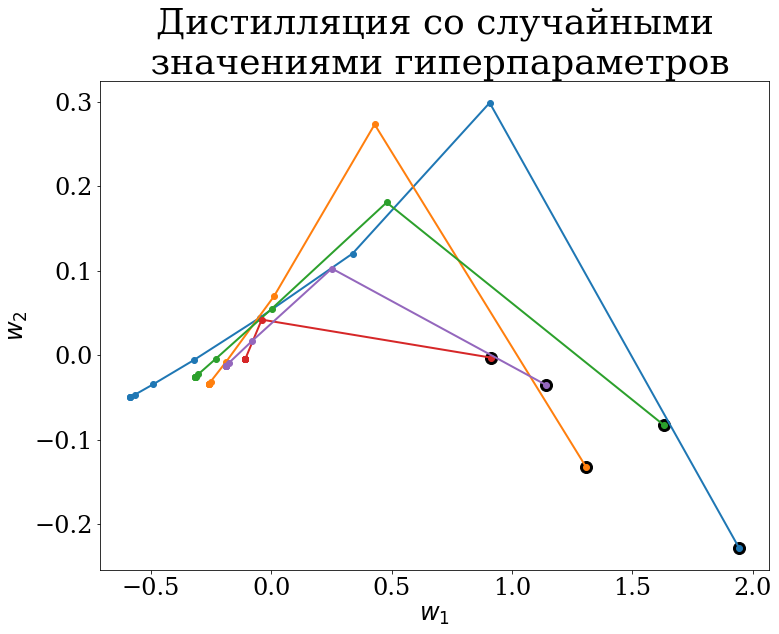

In [82]:
pca = PCA(n_components=2)
for res in res_full:
    par = pca.fit_transform(res)
    # for i in range(3):
    #     ax.plot(beta_h[:, i], beta2_h[:, i], temp_h[:, i], label='оптимизация гипепараметров')
    plt.plot(par[:, 0],par[:, 1], marker='.', label='')
    plt.scatter(par[0, 0], par[0, 1], color='black')

    plt.title('Дистилляция со случайными\n значениями гиперпараметров')
    plt.xlabel('$w_1$')
    plt.ylabel('$w_2$')
    #plt.legend()
plt.savefig('plot_params_rand.pdf')
plt.show()

# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)